In [1]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import gensim
from gensim.models import word2vec
from sklearn.linear_model import LogisticRegression
from statsmodels.discrete.discrete_model import Probit
#from sklearn import metrics
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
#nltk.download("stopwords")
stop_words =  set(stopwords.words('french'))

random.seed(1)
np.random.seed(1)

### Paramètres généraux

In [2]:
# chemins

os.chdir('C:/Users/torna/Documents/StatApp/StatApp')
#os.chdir('C:/Users/Kim Antunez/Documents/Projets_autres/StatApp')
#os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')
#os.chdir('/home/aqlt/Documents/Ensae/StatApp')

In [3]:
# pour gensim

nom_dossier = 'ens'
dim = 100
epoch = 100
window = 4
learning_rate = 0.02


In [24]:
# pour les train et test
rm_stopwords = True #True = on enlève les stopwords
lowfrequency_zero_bool= False #true : on met les non reconnus à zero. false : à lowfreq
git = True #True : base git, False : base sncf
logit_bool = True #True : régression logistique, False : probit
########
if rm_stopwords:
    rm_stopwords_string = "rmsw"
else:
    rm_stopwords_string = "nrmsw"
    
#false : on les met à 0 #Rq : le terme est mal choisi, à modifier plus tard
if lowfrequency_zero_bool:
    lowfrequency_zero_string = "z"
else:
    lowfrequency_zero_string = "lf"
    
if git:
    git_string = ""
else:
    git_string = "_sncf"


# Importer le modèle Word2Vec

In [25]:
chemin1 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed1".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model1 = gensim.models.keyedvectors.KeyedVectors.load(chemin1 + "/word2vec.model")
chemin2 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed5".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model2 = gensim.models.keyedvectors.KeyedVectors.load(chemin2 + "/word2vec.model")
chemin3 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed10".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model3 = gensim.models.keyedvectors.KeyedVectors.load(chemin3 + "/word2vec.model")
chemin4 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed15".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model4 = gensim.models.keyedvectors.KeyedVectors.load(chemin4 + "/word2vec.model")
chemin5 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed20".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model5 = gensim.models.keyedvectors.KeyedVectors.load(chemin5 + "/word2vec.model")
chemin6 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed25".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model6 = gensim.models.keyedvectors.KeyedVectors.load(chemin6 + "/word2vec.model")

In [26]:
matrice = {word : (model1.wv[word]+model2.wv[word]+model3.wv[word]+model4.wv[word]+model5.wv[word]+model6.wv[word])/6
           for word in model1.wv.index2word}

#def normalize(v):
#    norm = np.linalg.norm(v)
#    if norm == 0: 
#        return v
#    return v / norm

#matrice_norm = {word : normalize(matrice[word]) for word in matrice.keys()}

# Fonctions utiles 

In [27]:
def calcul_sentence_embedding(phrase,pond=False,lowfrequency_zero=lowfrequency_zero_bool):
    
    if len(phrase)>0: 
        if(pond): #Modèle de la fin non utilisé
            sum1 = sum(matrice[mot]*matrice_sentiments_val[mot] for mot in phrase if mot in model1.wv.index2word and
                   mot in vocabulaire)
            if lowfrequency_zero==False:
                sum2 = sum(matrice["lowfrequencyword"]*0 for mot in phrase if mot not in model1.wv.index2word)
                return (sum1+sum2)/len(phrase)
            else:
                return  (sum1)/(len([mot for mot in phrase if mot in model1.wv.index2word]))
        else:     
            sum1 = sum(matrice[mot] for mot in phrase if mot in model1.wv.index2word)
            #sum1 = sum(matrice_norm[mot] for mot in phrase if mot in model1.wv.index2word)
            if lowfrequency_zero==False:
                sum2 = sum(matrice["lowfrequencyword"] for mot in phrase if mot not in model1.wv.index2word)
                #sum2 = sum(matrice_norm["lowfrequencyword"] for mot in phrase if mot not in model1.wv.index2word)
                return (sum1+sum2)/len(phrase)
            else:
                taille = len([mot for mot in phrase if mot in model1.wv.index2word])
                if taille>0:
                    return  (sum1)/taille
                else: 
                    return 'NaN'
    else:
        if lowfrequency_zero==False:
            return matrice["lowfrequencyword"]
        else:
            return 'NaN'

In [28]:
def regression_logistique(X_train,Y_train,logit=logit_bool):
    if logit: #logit
        lr = LogisticRegression()
        reg_log = lr.fit(X_train,Y_train)
    else: #probit
        Y_train_prob = [max(val,0) for val in Y_train]
        model = Probit(Y_train_prob, X_train)
        reg_log = model.fit()
    return(reg_log)

In [29]:
def matrice_confusion_accuracy(Y,Y_pred): #X_train, Y_train
    cm = metrics.confusion_matrix(Y,Y_pred)
    print("Matrice de confusion :", cm)
    acc = metrics.accuracy_score(Y,Y_pred)
    print("Accuracy :", acc)

In [47]:
def courbe_roc(Y,Y_pred): #Y_pred = Y_test_pred #Y = Y_test
    preds = Y_pred[:,1]
    fpr, tpr, threshold = metrics.roc_curve(Y, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Courbe ROC - Régression logistique')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Taux de vrais positifs')
    plt.xlabel('Taux de faux positifs')
    plt.show()
    #print(roc_auc)

In [78]:
def calcul_AUC(Y,Y_pred,logit=True): #Y_pred = Y_test_pred #Y = Y_test
    if logit:
        preds = Y_pred[:,1]
        fpr, tpr, threshold = metrics.roc_curve(Y, preds)
    else:
        fpr, tpr, threshold = metrics.roc_curve(Y, Y_pred)    
    roc_auc = metrics.auc(fpr, tpr)
    return(roc_auc)

In [31]:
def mots_corpus_absents_dans_word2vec(corpus):
    phrases = [tweet.split() for (score, tweet) in corpus]
    mots = [item for sublist in phrases for item in sublist]
    vocabulaire = list(dict.fromkeys(mots))
    n = 0
    #absents = []
    for word in vocabulaire:
        if word not in model1.wv.index2word:
            n+=1
            #absents.append(word)
    return((n/len(vocabulaire)))

In [32]:
def suppr_stop(phrase):
    return [mot for mot in phrase if mot not in stop_words]

In [33]:
def sentiment_plus(mot, matrice_sentiments):
    plus, moins = matrice_sentiments[mot]
    matrice_sentiments[mot] = (plus+1,moins)
    
def sentiment_moins(mot, matrice_sentiments):
    plus, moins = matrice_sentiments[mot]
    matrice_sentiments[mot] = (plus,moins+1)

def mat_sentiments(corpus_train, vocabulaire):   
    #Initialisation
    matrice_sent = {mot:(0,0) for mot in vocabulaire}
    for (score, tweet) in corpus_train:
        for mot in tweet.split():
            if score == 1:
                sentiment_plus(mot, matrice_sent)
            else:
                sentiment_moins(mot,matrice_sent)
    matrice_sentiments_val = {mot:(matrice_sent[mot][0]-matrice_sent[mot][1])/((matrice_sent[mot][0]+matrice_sent[mot][1]))
                          for mot in vocabulaire}
    return matrice_sentiments_val

In [34]:
# Créer un DF avec les colonnes suivantes
#Phrases positives 	Phrases négatives 	Phrases positives mal prédites
#Phrases négatives mal prédites 	Pourcentage pos 	Pourcentage neg
def creer_df_mots_pos_neg(phrases_test, phrases_pos_faux, phrases_neg_faux):
    mots = [mot for (tweet,score) in phrases_test for mot in tweet]
    voc_faux = list(dict.fromkeys(mots))
    app_voc = {mot : [0,0,0,0] for mot in voc_faux}
    for phrase, score in phrases_test:
        for mot in phrase:
            plus, moins,faux_plus,faux_moins = app_voc[mot]
            if score == 1:
                app_voc[mot] = [plus+1,moins,faux_plus,faux_moins]
            else:
                app_voc[mot] = [plus,moins+1,faux_plus,faux_moins]
    for [tweet, proba] in phrases_pos_faux:
        for mot in tweet:
            plus, moins,faux_plus,faux_moins = app_voc[mot]
            app_voc[mot] = [plus,moins,faux_plus+1,faux_moins]
    for [tweet, proba] in phrases_neg_faux:
        for mot in tweet:
            plus, moins,faux_plus,faux_moins = app_voc[mot]
            app_voc[mot] =  [plus,moins,faux_plus,faux_moins+1] 
    donnees = [val for val in app_voc.values()]
    mots = [mot for mot in app_voc.keys()]
    df = pd.DataFrame(donnees,index=mots,columns=["Phrases positives","Phrases négatives","Phrases positives mal prédites","Phrases négatives mal prédites"])

    df["Part Phrases pos"] = 100 * df["Phrases positives"]/(df["Phrases positives"]+df["Phrases négatives"]) 
    df["Part Phrases pos mal préd"] =100 * df["Phrases positives mal prédites"]/ df["Phrases positives"]
    df["Part Phrases neg mal préd"] =100 * df["Phrases négatives mal prédites"]/ df["Phrases négatives"]
    df = df.sort_values(by=['Part Phrases pos mal préd'],ascending=False)
    df = df.loc[ : , ['Part Phrases pos', 'Part Phrases pos mal préd','Part Phrases neg mal préd'] ]
    return df

In [35]:
def nb_mots_PasWord2vec_phrase(phrase):
    compteur = 0
    for mot in phrase:
        if mot not in model1.wv.index2word:
            compteur = compteur + 1
    return compteur

# Modèle logistique

In [37]:
# Si on veut récup les fichiers

with open("data/sentimental_analysis/corpus_test{}.file".format(git_string), "rb") as f:
    corpus_test = pickle.load(f)
with open("data/sentimental_analysis/corpus_train{}.file".format(git_string), "rb") as f:
    corpus_train = pickle.load(f)
with open("data/sentimental_analysis/phrasesEmbTest_{}_{}.file".format(rm_stopwords_string,lowfrequency_zero_string), "rb") as f:
    phrases_test_emb = pickle.load(f)
with open("data/sentimental_analysis/phrasesEmbTrain_{}_{}.file".format(rm_stopwords_string,lowfrequency_zero_string), "rb") as f:
    phrases_train_emb = pickle.load(f)

In [38]:
phrases = [tweet.split() for (score, tweet) in corpus_train]
mots = [item for sublist in phrases for item in sublist]
vocabulaire = list(dict.fromkeys(mots))
print("Nombre de mots :", len(mots))
print("Taille du vocabulaire :", len(vocabulaire))

Nombre de mots : 674732
Taille du vocabulaire : 39650


Mots du corpus de train absents du vocabulaire word2vec (en %) 

In [39]:
100 * mots_corpus_absents_dans_word2vec(corpus_train)

53.477931904161416

Mots du corpus de test absents du vocabulaire word2vec (en %) 

In [40]:
100 * mots_corpus_absents_dans_word2vec(corpus_test)

29.000584453535943

données de train

In [41]:
if rm_stopwords:
    phrases = [[suppr_stop(tweet.split()),score] for (score, tweet) in corpus_train]
else:
    phrases = [[tweet.split(),score] for (score, tweet) in corpus_train]
# long à tourner : chargé ci-dessus. 
#phrases_train_emb = [[score,calcul_sentence_embedding(phrase,lowfrequency_zero=lowfrequency_zero_bool)] for (phrase,score) in phrases]
#with open("data/sentimental_analysis/phrasesEmbTrain_{}_{}.file".format(rm_stopwords_string,lowfrequency_zero_string), "wb") as f:
#        pickle.dump(phrases_train_emb, f, pickle.HIGHEST_PROTOCOL)
phrases_train_emb = [[score,phrase] for (score,phrase) in phrases_train_emb if phrase != 'NaN']
Y_train = [score for (score, embedding) in phrases_train_emb]
X_train = [embedding for (score, embedding) in phrases_train_emb]


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


données de test

In [42]:
if rm_stopwords:
    phrases_test = [[suppr_stop(tweet.split()),score] for (score, tweet) in corpus_test]
else:
    phrases_test = [[tweet.split(),score] for (score, tweet) in corpus_test]
# long à tourner : chargé ci-dessus. 
#phrases_test_emb = [[score,calcul_sentence_embedding(phrase,lowfrequency_zero=lowfrequency_zero_bool)] for (phrase,score) in phrases_test]
#with open("data/sentimental_analysis/phrasesEmbTest_{}_{}.file".format(rm_stopwords_string,lowfrequency_zero_string), "wb") as f:
#        pickle.dump(phrases_test_emb, f, pickle.HIGHEST_PROTOCOL)
phrases_test_emb = [[score,phrase] for (score,phrase) in phrases_test_emb if phrase != 'NaN']
Y_test = [score for (score, embedding) in phrases_test_emb]
X_test = [embedding for (score, embedding) in phrases_test_emb]

C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


#### Régression logistique (en enlevant les stop_words)

In [43]:
reg_log = regression_logistique(X_train, Y_train, logit = True)
Y_train_pred = reg_log.predict(X_train)
Y_test_pred = reg_log.predict(X_test)
Y_train_proba = reg_log.predict_proba(X_train)
Y_test_proba = reg_log.predict_proba(X_test)

In [44]:
print("TRAIN")
matrice_confusion_accuracy(Y_train,Y_train_pred)
print("\nTEST")
matrice_confusion_accuracy(Y_test,Y_test_pred)

TRAIN
Matrice de confusion : [[16922  8078]
 [ 8102 16898]]
Accuracy : 0.6764

TEST
Matrice de confusion : [[1350  634]
 [ 685 1313]]
Accuracy : 0.6687594173782019


Valeur prédite pour lowfrequency ?

In [45]:
if lowfrequency_zero_bool==False:
    phrases_lf = [['lowfrequency'],1]
    phrases_lf_emb = [phrases_lf[1],calcul_sentence_embedding([phrases_lf[1]],lowfrequency_zero=lowfrequency_zero_bool)]
    lf_pred = reg_log.predict([phrases_lf_emb[1]])
    print(lf_pred)

[1]


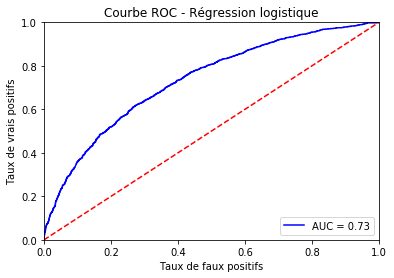

0.7328505420743324


In [48]:
courbe_roc(Y_test,Y_test_proba)

Distribution de proba

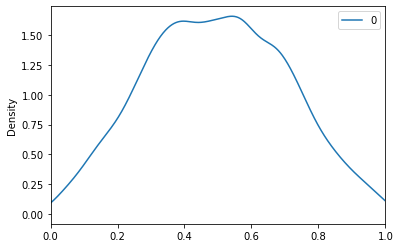

In [221]:
probas = Y_test_proba[:,1]
pd.DataFrame(probas).plot(kind='density',xlim=(0,1)) 

In [168]:
# On sauve les modèles
#with open("data/sentimental_analysis/reg_log_{}_{}{}.file".format(rm_stopwords_string,lowfrequency_zero_string, git_string), "wb") as f:
#        pickle.dump(reg_log, f, pickle.HIGHEST_PROTOCOL)

#### Régression probit (en enlevant les stop_words)

In [69]:
reg_log = regression_logistique(X_train,Y_train,logit=False)
Y_train_pred = reg_log.predict(X_train)
Y_test_pred = reg_log.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.601140
         Iterations 5


In [70]:
print("TRAIN")
matrice_confusion_accuracy(Y_train,[1 if (val >= 0.5) else -1 for val in Y_train_pred])
print("\nTEST")
matrice_confusion_accuracy(Y_test,[1 if (val >= 0.5) else -1 for val in Y_test_pred]) 

TRAIN
Matrice de confusion : [[17062  7938]
 [ 8226 16774]]
Accuracy : 0.67672

TEST
Matrice de confusion : [[1358  626]
 [ 693 1305]]
Accuracy : 0.6687594173782019


Valeur prédite pour lowfrequency ?

In [224]:
if lowfrequency_zero_bool==False:
    phrases_lf = [['lowfrequency'],1]
    phrases_lf_emb = [phrases_lf[1],calcul_sentence_embedding([phrases_lf[1]],lowfrequency_zero=lowfrequency_zero_bool)]
    lf_pred = reg_log.predict([phrases_lf_emb[1]])
    print(lf_pred)

[0.6706915]


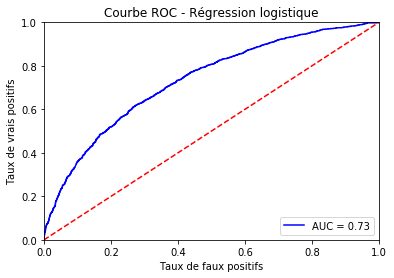

In [225]:
courbe_roc(Y_test,Y_test_proba) #Y_test_proba => logit ??

In [74]:
fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_test_pred)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.7325215840840842


Distribution de proba

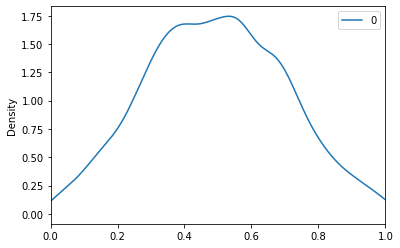

In [226]:
pd.DataFrame(Y_test_pred).plot(kind='density',xlim=(0,1))

In [174]:
# On sauve les modèles
#with open("data/sentimental_analysis/reg_prob_{}_{}{}.file".format(rm_stopwords_string,lowfrequency_zero_string, git_string), "wb") as f:
#        pickle.dump(reg_log, f, pickle.HIGHEST_PROTOCOL)

# Identifier mal prédits

**Attention** Avant de faire tourner cette partie, faire tourner le dernier type de modèle souhaité ci-dessus (logit ou probit). 

In [227]:
phrases_pred = [(tweet,score,pred,proba) for (tweet,score),pred,proba in zip(phrases_test,Y_test_pred,probas)]
phrases_tot = [[tweet,proba] for (tweet,score,pred,proba) in phrases_pred]
phrases_pos_faux = [[tweet,proba] for (tweet,score,pred,proba) in phrases_pred if (score == 1 and pred==-1)]
probas_pos = [proba for [tweet,proba] in phrases_pos_faux]
phrases_neg_faux = [[tweet,proba] for (tweet,score,pred,proba) in phrases_pred if (score == -1 and pred==1)]
probas_neg = [proba for [tweet,proba] in phrases_neg_faux]

phrases_tot_compt = [[phrase, nb_mots_PasWord2vec_phrase(phrase),len(phrase)] for [phrase,score] in phrases_tot]
phrases_pos_faux_compt = [[phrase, nb_mots_PasWord2vec_phrase(phrase),len(phrase)] for [phrase,score] in phrases_pos_faux]
phrases_neg_faux_compt = [[phrase, nb_mots_PasWord2vec_phrase(phrase),len(phrase)] for [phrase,score] in phrases_neg_faux]

# pourcentage des mots qui sont dans pas dans word2vec
phrases_tot_pourcent = [[phrase,val1/val2] for [phrase,val1,val2] in phrases_tot_compt if val2>0]
phrases_pos_faux_pourcent = [[phrase,val1/val2] for [phrase,val1,val2] in phrases_pos_faux_compt if val2>0]
phrases_neg_faux_pourcent = [[phrase,val1/val2] for [phrase,val1,val2] in phrases_neg_faux_compt if val2>0]
val_tot_pourcent = [val for [phrase,val] in phrases_tot_pourcent]
val_pos_faux_pourcent = [val for [phrase,val] in phrases_pos_faux_pourcent]
val_neg_faux_pourcent = [val for [phrase,val] in phrases_neg_faux_pourcent]

Densités

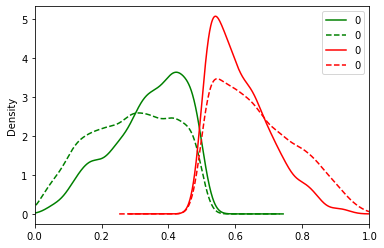

In [204]:
ax = plt.gca()
# Négatifs (plein) et Faux négatifs (pointillés)
pd.DataFrame(probas_pos).plot(kind='density',xlim=(0,1),ax=ax,color='green')
pd.DataFrame(probas[probas<0.5]).plot(kind='density',xlim=(0,1),ax=ax,color='green',linestyle='dashed') 
# Positifs (plein) et Faux positifs (pointillés)
pd.DataFrame(probas_neg).plot(kind='density',xlim=(0,1),ax=ax,color='red')
pd.DataFrame(probas[probas>0.5]).plot(kind='density',xlim=(0,1),ax=ax,linestyle='dashed',color='red') 
plt.show()

In [205]:
df = creer_df_mots_pos_neg(phrases_test, phrases_pos_faux, phrases_neg_faux)
#df.to_csv('test.csv', sep = ';',encoding='UTF8')
df

,Part Phrases pos,Part Phrases pos mal préd,Part Phrases neg mal préd
tropdelove,100.000000,100.0,NaN
demandes,33.333333,100.0,0.0
pensantes,100.000000,100.0,NaN
44,100.000000,100.0,NaN
milliards,100.000000,100.0,NaN
...,...,...,...
pure,0.000000,NaN,100.0
foooolie,0.000000,NaN,100.0
moi😭,0.000000,NaN,0.0
trouduculs,0.000000,NaN,100.0


In [206]:
df_pos = pd.DataFrame(val_pos_faux_pourcent,columns=["val"])
print("Part des phrases contenant au moins 1 mot inconnu à word2vec parmi les faux négatifs",
      round(100 - 100 * df_pos[df_pos["val"]>0].shape[0] / df_pos.shape[0],0))

df_neg = pd.DataFrame(val_neg_faux_pourcent,columns=["val"])
print("Part des phrases contenant au moins 1 mot inconnu à word2vec parmi les faux positifs",
      round(100 - 100 * df_neg[df_neg["val"]>0].shape[0] / df_neg.shape[0],0))

df_tot = pd.DataFrame(val_tot_pourcent,columns=["val"])
print("Part des phrases contenant au moins 1 mot inconnu à word2vec parmi toutes les phrases",
      round(100 - 100 * df_tot[df_tot["val"]>0].shape[0] / df_tot.shape[0],0))

Part des phrases contenant au moins 1 mot inconnu à word2vec parmi les faux négatifs 52.0
Part des phrases contenant au moins 1 mot inconnu à word2vec parmi les faux positifs 43.0
Part des phrases contenant au moins 1 mot inconnu à word2vec parmi toutes les phrases 48.0


# Sélection du meilleur modèle

In [87]:
def calculate_aic(n, mse, num_params = 100):
    aic = n * log(mse) + 2 * num_params
    return aic

def calculate_bic(n, mse, num_params = 100):
    bic = n * log(mse) + num_params * log(n)
    return bic

In [98]:
import random
from random import sample
from sklearn.metrics import mean_squared_error
from math import log

def selection_regression():
    for git_string in [True,False]:
        print("Données GIT : ", git_string)
        for logit_bool in [True,False]:
            print("Logit ? : ", logit_bool)
            for rm_stopwords_string in ["rmsw","nrmsw"]:
                print("Stopwords ? : ", rm_stopwords_string)
                for lowfrequency_zero_string in ["z","lf"]:
                    print("Lowfrequency : ", lowfrequency_zero_string)
                    if git_string:
                        with open("data/sentimental_analysis/phrasesEmbTest_{}_{}.file".format(rm_stopwords_string,
                                                                                                  lowfrequency_zero_string
                                                                                              ), "rb") as f:
                            phrases_test_emb = pickle.load(f)
                        with open("data/sentimental_analysis/phrasesEmbTrain_{}_{}.file".format(rm_stopwords_string,
                                                                                                  lowfrequency_zero_string
                                                                                              ), "rb") as f:
                            phrases_train_emb = pickle.load(f)
                    else:
                        with open("data/sentimental_analysis/phrasesEmbTest_{}_{}_sncf.file".format(rm_stopwords_string,
                                                                                                  lowfrequency_zero_string
                                                                                              ), "rb") as f:
                            phrases_test_emb = pickle.load(f)
                        with open("data/sentimental_analysis/phrasesEmbTrain_{}_{}_sncf.file".format(rm_stopwords_string,
                                                                                                  lowfrequency_zero_string
                                                                                              ), "rb") as f:
                            phrases_train_emb = pickle.load(f)
                    phrases_train_emb = [[score,phrase] for (score,phrase) in phrases_train_emb if phrase != 'NaN']
                    Y_train = [score for (score, embedding) in phrases_train_emb]
                    X_train = [embedding for (score, embedding) in phrases_train_emb]
                    phrases_test_emb = [[score,phrase] for (score,phrase) in phrases_test_emb if phrase != 'NaN']
                    random.seed(1)
                    for i in range(5):
                        phrases_test_emb_1 = sample(phrases_test_emb,round(0.8*len(phrases_test_emb)))
                        Y_test = [score for (score, embedding) in phrases_test_emb_1]
                        X_test = [embedding for (score, embedding) in phrases_test_emb_1]
                        reg_log = regression_logistique(X_train,Y_train,logit=logit_bool)
                        if logit_bool:
                            Y_test_pred = reg_log.predict_proba(X_test)
                            Y1 = reg_log.predict(X_test)
                        else:
                            Y_test_pred = reg_log.predict(X_test)
                            Y1 = [1 if (val >= 0.5) else -1 for val in Y_test_pred]
                        n = len(phrases_test_emb_1)
                        mse = mean_squared_error(Y_test, Y1)
                        print("Test ", i," : ",calcul_AUC(Y_test,Y_test_pred,logit_bool), " - AIC : ", 
                        calculate_aic(n, mse), " - BIC : ", calculate_bic(n, mse))

In [99]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
selection_regression()

Données GIT :  True
Logit ? :  True
Stopwords ? :  rmsw
Lowfrequency :  z
Test  0  :  0.7315647938505668  - AIC :  1093.4593194245626  - BIC :  1699.00683360029
Test  1  :  0.7286790567626477  - AIC :  1123.440516114421  - BIC :  1728.9880302901483
Test  2  :  0.7348735609215259  - AIC :  1087.4286955741852  - BIC :  1692.9762097499126
Test  3  :  0.7406654693069818  - AIC :  1029.5546665565776  - BIC :  1635.102180732305
Test  4  :  0.7228329754360237  - AIC :  1150.1818364418516  - BIC :  1755.729350617579
Lowfrequency :  lf
Test  0  :  0.738426714974151  - AIC :  1049.8618768340143  - BIC :  1656.5140258810134
Test  1  :  0.7371667783858296  - AIC :  1071.2342617241013  - BIC :  1677.8864107711006
Test  2  :  0.7335052066420548  - AIC :  1110.5494260106466  - BIC :  1717.2015750576456
Test  3  :  0.7316336068700485  - AIC :  1086.4129469369007  - BIC :  1693.0650959839
Test  4  :  0.729781364232016  - AIC :  1113.5536695147212  - BIC :  1720.2058185617207
Stopwords ? :  nrmsw
Lowfre

Optimization terminated successfully.
         Current function value: 0.576595
         Iterations 5
Test  2  :  0.7587695694716243  - AIC :  1210.8723708301281  - BIC :  1871.867837979883
Optimization terminated successfully.
         Current function value: 0.576595
         Iterations 5
Test  3  :  0.7524161265881236  - AIC :  1387.6442273836763  - BIC :  2048.6396945334313
Optimization terminated successfully.
         Current function value: 0.576595
         Iterations 5
Test  4  :  0.7589189375837163  - AIC :  1197.5487455804735  - BIC :  1858.5442127302285
Lowfrequency :  lf
Optimization terminated successfully.
         Current function value: 0.575678
         Iterations 5
Test  0  :  0.7565152308530594  - AIC :  1257.2518741205697  - BIC :  1918.2473412703248
Optimization terminated successfully.
         Current function value: 0.575678
         Iterations 5
Test  1  :  0.7599952093196949  - AIC :  1224.1637159143072  - BIC :  1885.1591830640623
Optimization terminated suc

In [100]:
def selection_regression_croisee():#Changement par rapport au précédent = bases de test, on teste les modèles GIT sur
    # données SNCF et modèles SNCF sur données GIT
    for git_string in [True,False]:
        print("Données GIT : ", git_string)
        for logit_bool in [True,False]:
            print("Logit ? : ", logit_bool)
            for rm_stopwords_string in ["rmsw","nrmsw"]:
                print("Stopwords ? : ", rm_stopwords_string)
                for lowfrequency_zero_string in ["z","lf"]:
                    print("Lowfrequency : ", lowfrequency_zero_string)
                    if git_string:# Changement ici dans le chargement des bases tests
                        with open("data/sentimental_analysis/phrasesEmbTest_{}_{}_sncf.file".format(rm_stopwords_string,
                                                                                                  lowfrequency_zero_string
                                                                                              ), "rb") as f:
                            phrases_test_emb = pickle.load(f)
                        with open("data/sentimental_analysis/phrasesEmbTrain_{}_{}.file".format(rm_stopwords_string,
                                                                                                  lowfrequency_zero_string
                                                                                              ), "rb") as f:
                            phrases_train_emb = pickle.load(f)
                    else:
                        with open("data/sentimental_analysis/phrasesEmbTest_{}_{}.file".format(rm_stopwords_string,
                                                                                                  lowfrequency_zero_string
                                                                                              ), "rb") as f:
                            phrases_test_emb = pickle.load(f)
                        with open("data/sentimental_analysis/phrasesEmbTrain_{}_{}_sncf.file".format(rm_stopwords_string,
                                                                                                  lowfrequency_zero_string
                                                                                              ), "rb") as f:
                            phrases_train_emb = pickle.load(f)
                    phrases_train_emb = [[score,phrase] for (score,phrase) in phrases_train_emb if phrase != 'NaN']
                    Y_train = [score for (score, embedding) in phrases_train_emb]
                    X_train = [embedding for (score, embedding) in phrases_train_emb]
                    phrases_test_emb = [[score,phrase] for (score,phrase) in phrases_test_emb if phrase != 'NaN']
                    random.seed(1)
                    for i in range(5):
                        phrases_test_emb_1 = sample(phrases_test_emb,round(0.8*len(phrases_test_emb)))
                        Y_test = [score for (score, embedding) in phrases_test_emb_1]
                        X_test = [embedding for (score, embedding) in phrases_test_emb_1]
                        reg_log = regression_logistique(X_train,Y_train,logit=logit_bool)
                        if logit_bool:
                            Y_test_pred = reg_log.predict_proba(X_test)
                            Y1 = reg_log.predict(X_test)
                        else:
                            Y_test_pred = reg_log.predict(X_test)
                            Y1 = [1 if (val >= 0.5) else -1 for val in Y_test_pred]
                        n = len(phrases_test_emb_1)
                        mse = mean_squared_error(Y_test, Y1)
                        print("Test ", i," : ",calcul_AUC(Y_test,Y_test_pred,logit_bool), " - AIC : ", 
                        calculate_aic(n, mse), " - BIC : ", calculate_bic(n, mse))

In [101]:
selection_regression_croisee()

Données GIT :  True
Logit ? :  True
Stopwords ? :  rmsw
Lowfrequency :  z
Test  0  :  0.6774684639867647  - AIC :  2028.4303753309357  - BIC :  2689.425842480691
Test  1  :  0.6892085575905977  - AIC :  2034.1598797681697  - BIC :  2695.155346917925
Test  2  :  0.6839088660578386  - AIC :  2022.6948808200164  - BIC :  2683.690347969771
Test  3  :  0.6794753081401461  - AIC :  2079.7817643099024  - BIC :  2740.7772314596577
Test  4  :  0.6805471326677224  - AIC :  2110.9281705528047  - BIC :  2771.9236377025595
Lowfrequency :  lf
Test  0  :  0.6748411839029294  - AIC :  2150.3150064030424  - BIC :  2811.3104735527972
Test  1  :  0.6857030955489224  - AIC :  2139.090450057629  - BIC :  2800.085917207384
Test  2  :  0.6794611600347902  - AIC :  2150.3150064030424  - BIC :  2811.3104735527972
Test  3  :  0.6768759938474945  - AIC :  2161.516643781324  - BIC :  2822.512110931079
Test  4  :  0.6778293324219622  - AIC :  2189.421078307991  - BIC :  2850.416545457746
Stopwords ? :  nrmsw
Lowfr

Optimization terminated successfully.
         Current function value: 0.576595
         Iterations 5
Test  3  :  0.6721968004873238  - AIC :  1547.1804238485927  - BIC :  2152.72793802432
Optimization terminated successfully.
         Current function value: 0.576595
         Iterations 5
Test  4  :  0.6581773827701656  - AIC :  1614.2804204818676  - BIC :  2219.827934657595
Lowfrequency :  lf
Optimization terminated successfully.
         Current function value: 0.575678
         Iterations 5
Test  0  :  0.6695944606647218  - AIC :  1574.0739690473267  - BIC :  2180.726118094326
Optimization terminated successfully.
         Current function value: 0.575678
         Iterations 5
Test  1  :  0.672305824410578  - AIC :  1555.8309744179023  - BIC :  2162.483123464902
Optimization terminated successfully.
         Current function value: 0.575678
         Iterations 5
Test  2  :  0.6708103319451056  - AIC :  1534.8531208507231  - BIC :  2141.5052698977224
Optimization terminated successf